In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_curve,auc,f1_score
from sklearn.impute import SimpleImputer

# Importing all classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [5]:
# !python -m pip install seaborn 

In [6]:
# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
encode = LabelEncoder()

In [8]:
# Display first few rows of the training data
train.isna().sum()  
# Display first few rows of the test data
test.isna().sum()   
pd.DataFrame({'Train missing': train.isna().sum(), 'Test missing': test.isna().sum()})

,Train missing,Test missing
annual_income,0,0.0
credit_score,0,0.0
debt_to_income_ratio,0,0.0
education_level,0,0.0
employment_status,0,0.0
gender,0,0.0
grade_subgrade,0,0.0
id,0,0.0
interest_rate,0,0.0
loan_amount,0,0.0


In [9]:
# train.dtypes

In [10]:
# Encoding categorical variables
categorical_cols = train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    train[col] = encode.fit_transform(train[col])
    test[col] = encode.fit_transform(test[col])

In [11]:
# check skewness in target variable
train.head()   

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,0,2,1,2,6,12,1.0
1,1,22108.02,0.166,636,4593.10,12.92,1,1,2,0,2,17,0.0
2,2,49566.20,0.097,694,17005.15,9.76,1,2,1,0,2,14,1.0
3,3,46858.25,0.065,533,4682.48,16.10,0,2,1,0,2,25,1.0
4,4,25496.70,0.053,665,12184.43,10.21,1,1,1,0,6,15,1.0


In [12]:
# Check duplicates
# print("\nNumber of duplicate rows:", test.duplicated().sum())
# no duplicates

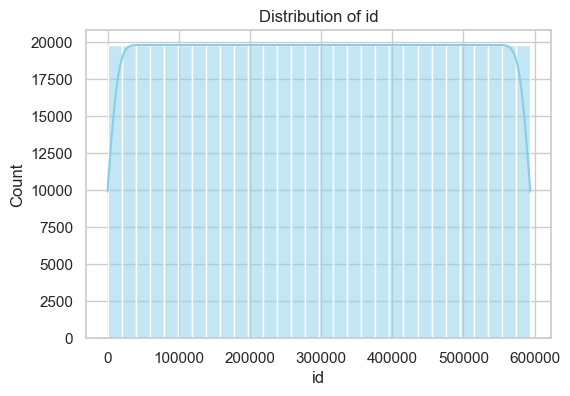

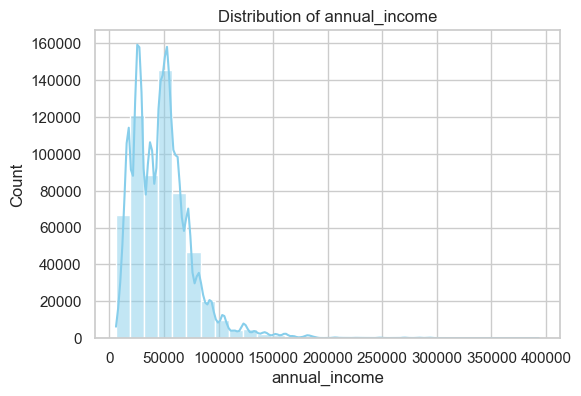

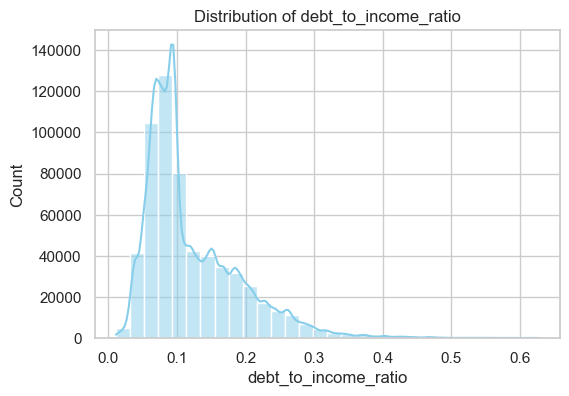

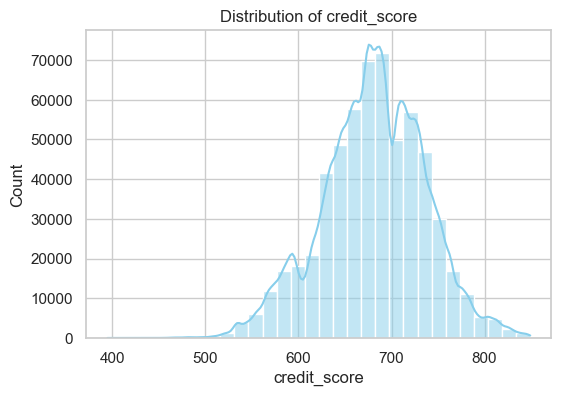

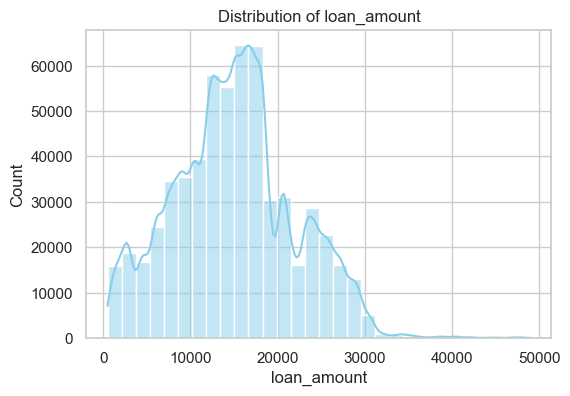

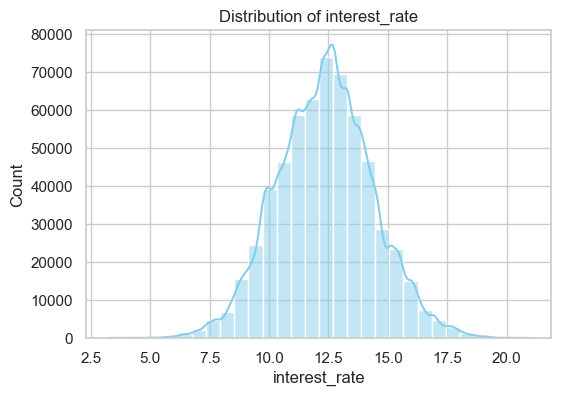

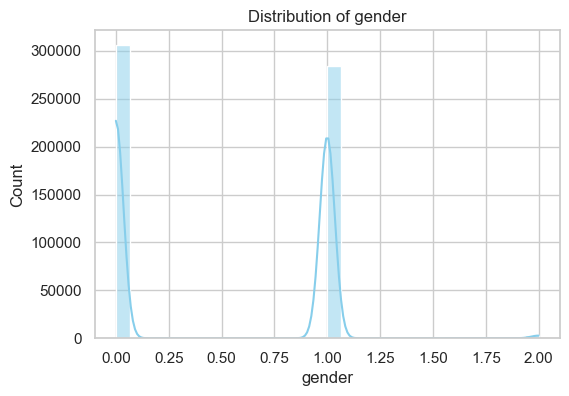

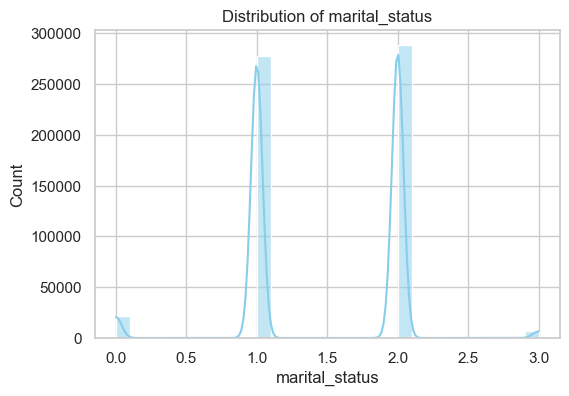

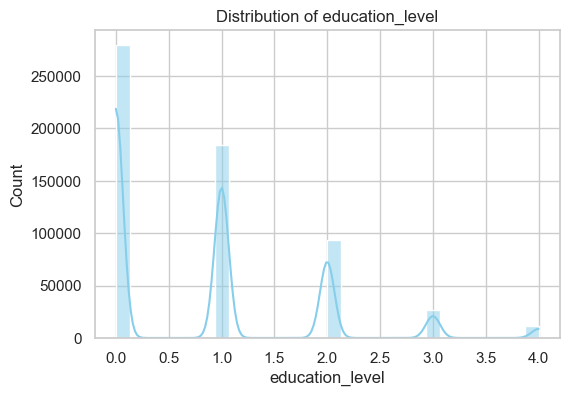

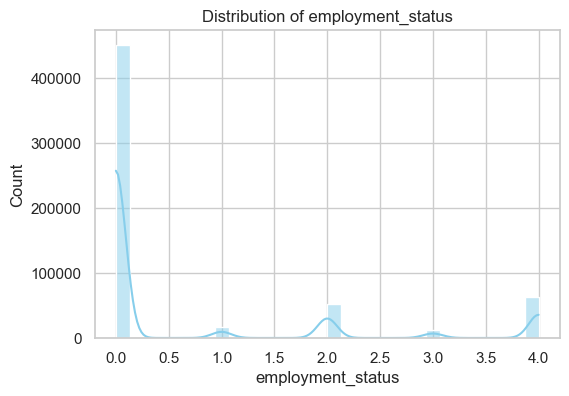

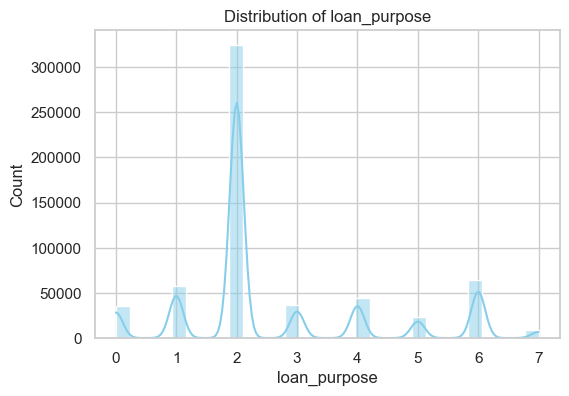

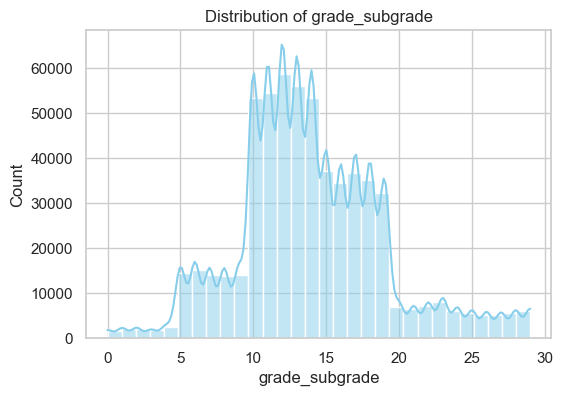

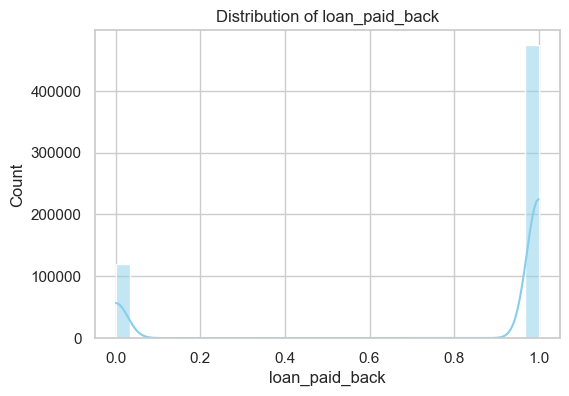

In [14]:
# ---- Numeric Columns ----
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [18]:
# ---- Categorical Columns ----
cat_cols = ['gender', 'marital_status', 'education_level', 
            'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=df[col], palette='viridis')
    plt.title(f'Count of {col}')
    plt.show()



NameError: name 'df' is not defined

<Figure size 600x400 with 0 Axes>

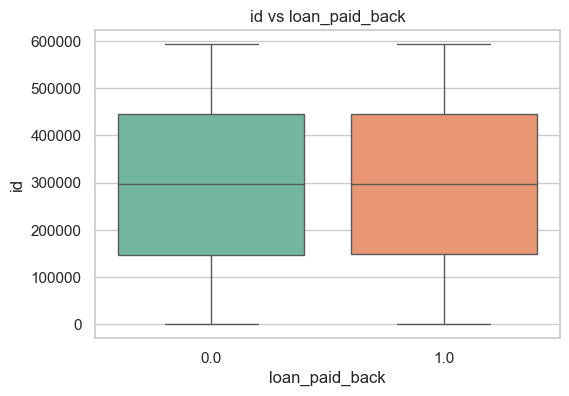

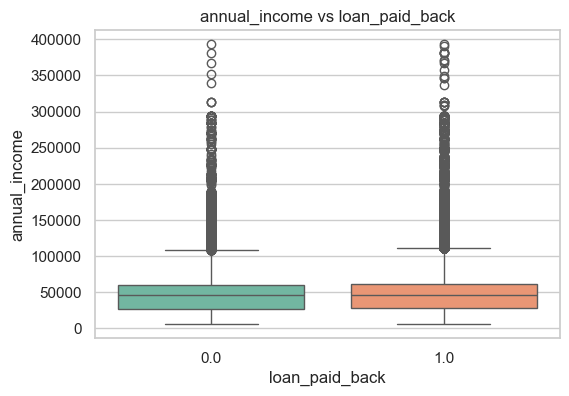

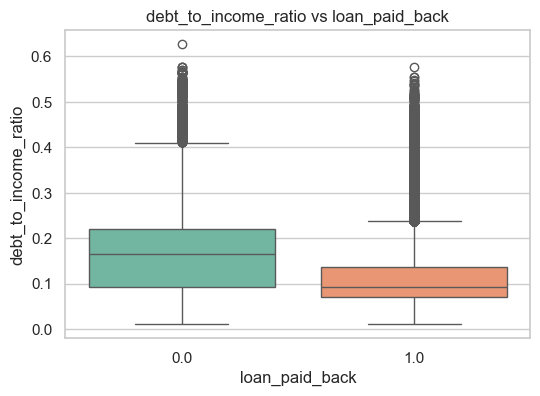

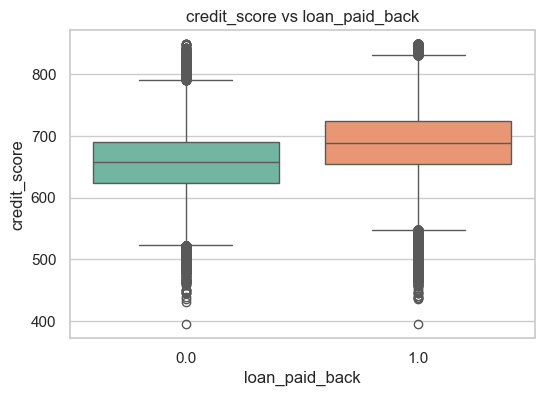

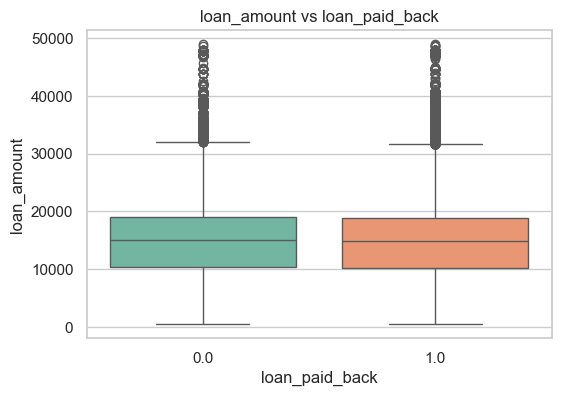

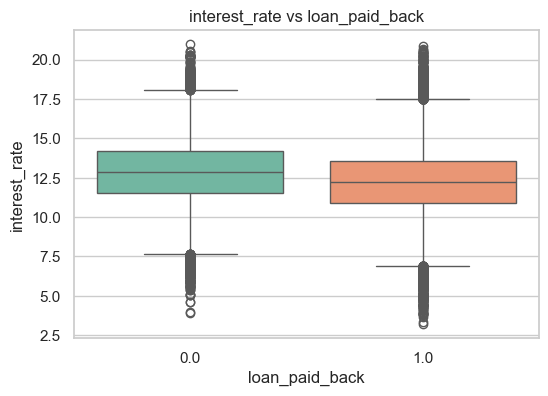

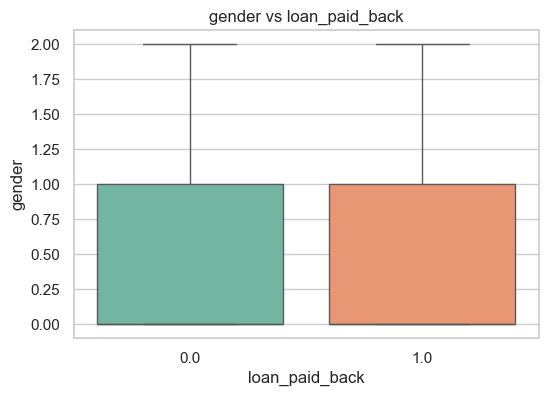

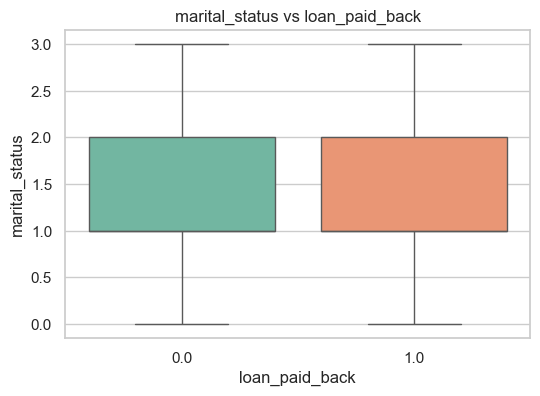

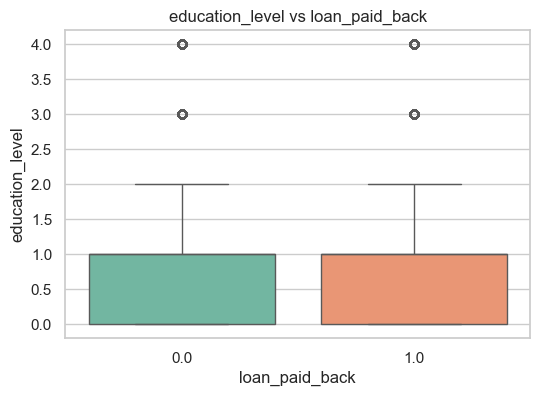

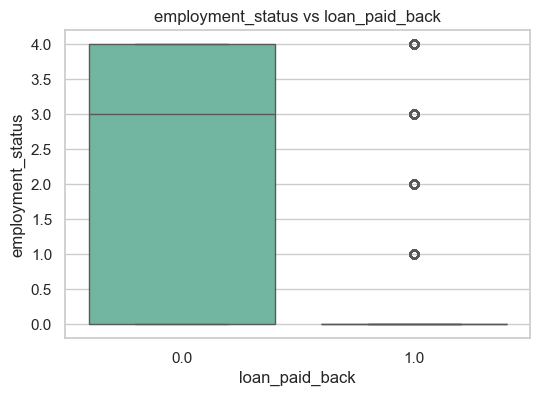

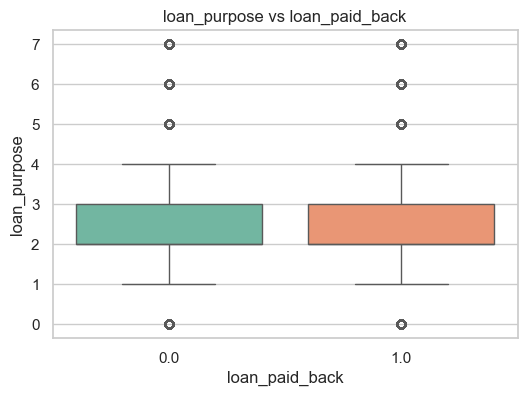

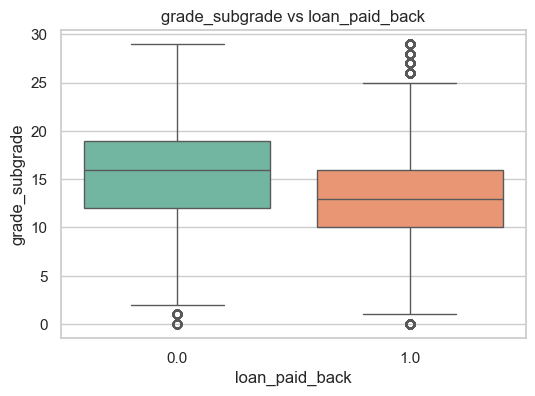

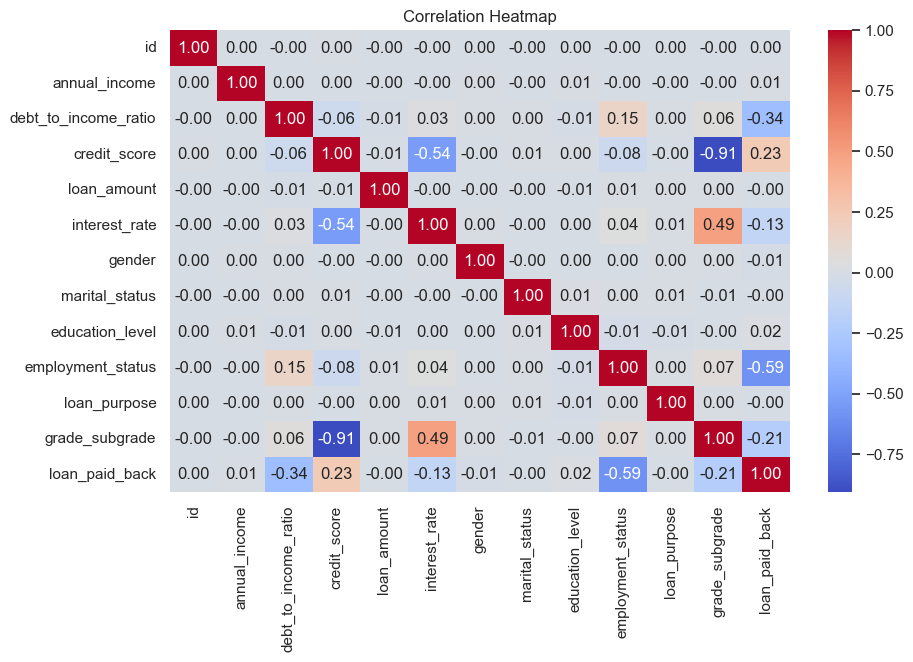

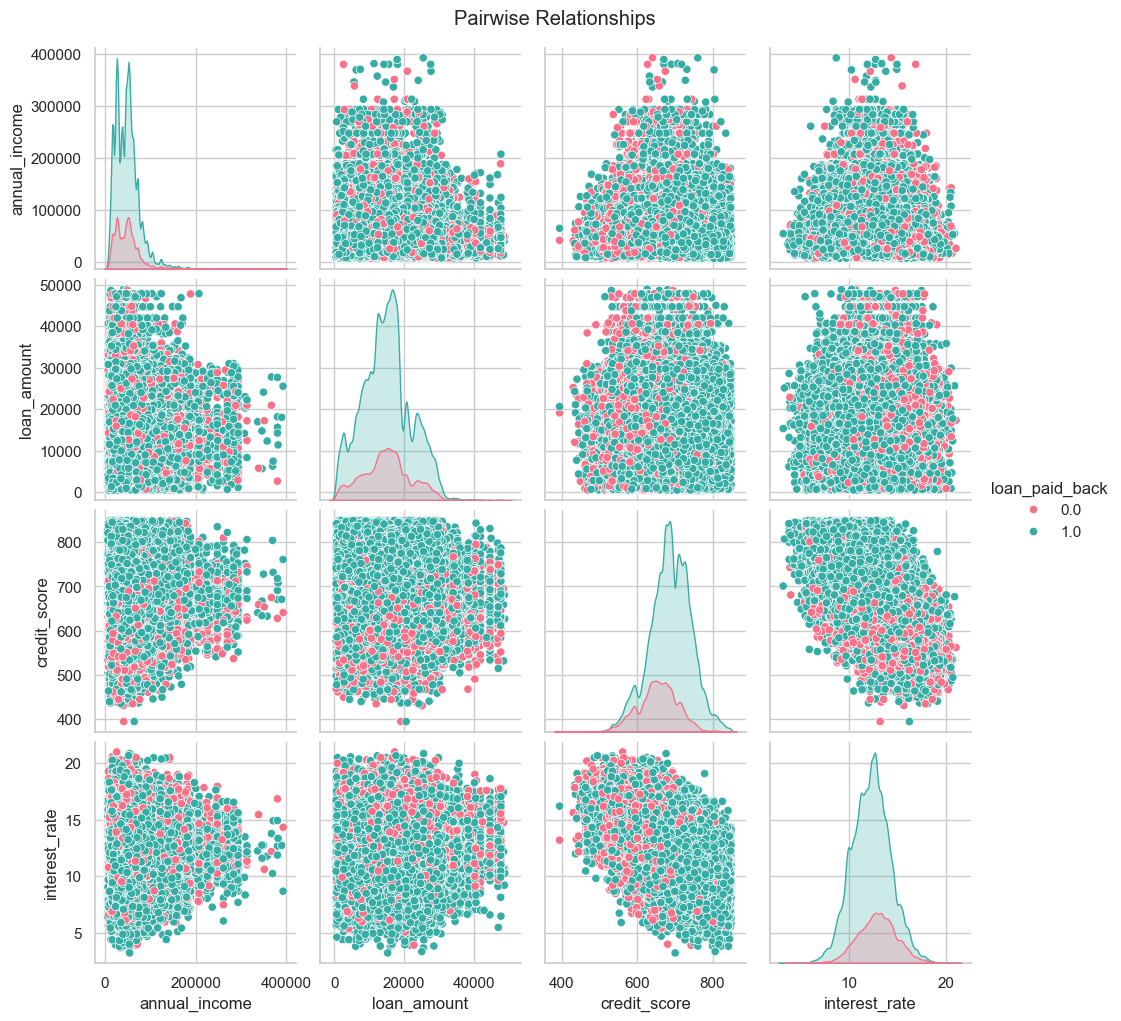

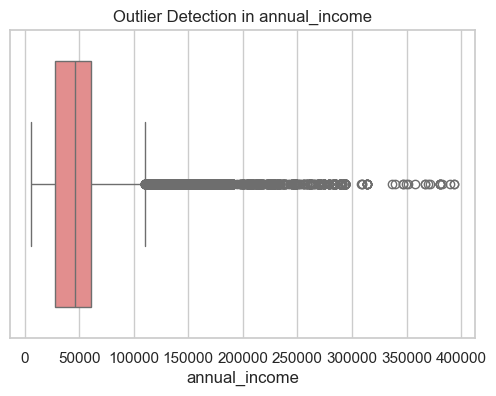

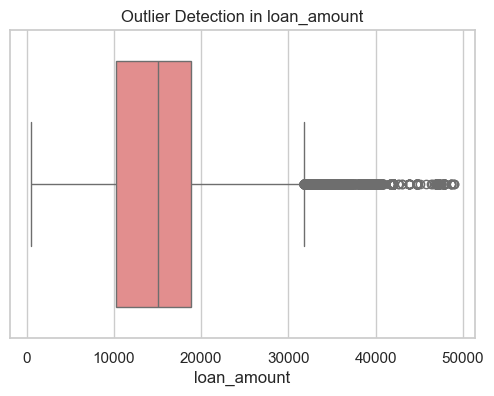

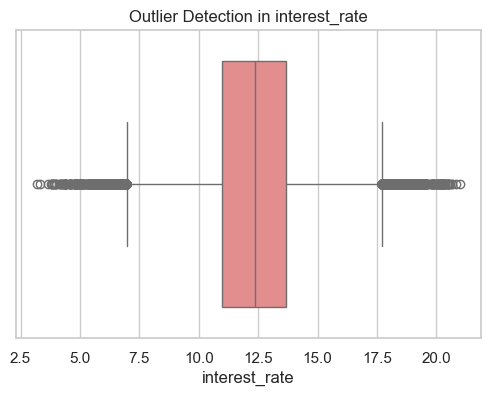

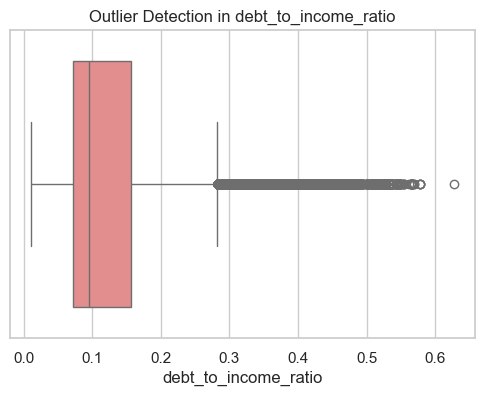

In [16]:
# ===========================
# 🔁 Bivariate Analysis
# ===========================

target = "loan_paid_back"  # Target column

# Numeric vs Target
for col in num_cols:
    if col != target:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=train, x=target, y=col, palette='Set2')
        plt.title(f"{col} vs {target}")
        plt.show()

# Categorical vs Target
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(data=train, x=col, y=target, estimator=np.mean, palette='coolwarm')
    plt.title(f"Mean {target} rate by {col}")
    plt.xticks(rotation=45)
    plt.show()

# ===========================
# 🔥 Correlation Analysis
# ===========================
plt.figure(figsize=(10,6))
corr = train[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# ===========================
# 🧩 Feature Relationships
# ===========================
sns.pairplot(train, vars=['annual_income', 'loan_amount', 'credit_score', 'interest_rate'],
             hue=target, diag_kind='kde', palette='husl')
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

# ===========================
# 🚨 Outlier Detection
# ===========================
for col in ['annual_income', 'loan_amount', 'interest_rate', 'debt_to_income_ratio']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=train[col], color='lightcoral')
    plt.title(f"Outlier Detection in {col}")
    plt.show()



In [20]:
# ===========================
# 📈 Summary Insights
# ===========================
print("\nAverage Loan Paid Back Rate:", train[target].mean())
print("\nDefault Rate by Loan Purpose:\n", train.groupby('loan_purpose')[target].mean())
print("\nDefault Rate by Grade/Subgrade:\n", train.groupby('grade_subgrade')[target].mean())
# 💡 Optional Additions
# If your categorical columns are encoded (like “Male/Female” or “Yes/No”), you can:

# train['gender'] = train['gender'].astype('category')
# train['loan_paid_back'] = train['loan_paid_back'].map({'Yes':1, 'No':0})


Average Loan Paid Back Rate: 0.7988195166954548

Default Rate by Loan Purpose:
 loan_purpose
0    0.813104
1    0.800630
2    0.796911
3    0.777053
4    0.823224
5    0.778085
6    0.802377
7    0.796071
Name: loan_paid_back, dtype: float64

Default Rate by Grade/Subgrade:
 grade_subgrade
0     0.952500
1     0.952924
2     0.955470
3     0.957084
4     0.944962
5     0.916341
6     0.937430
7     0.940040
8     0.931758
9     0.934204
10    0.860090
11    0.851165
12    0.836000
13    0.843987
14    0.846259
15    0.731886
16    0.720957
17    0.695972
18    0.714733
19    0.713000
20    0.652010
21    0.662743
22    0.641837
23    0.649577
24    0.669461
25    0.624503
26    0.617721
27    0.604093
28    0.637037
29    0.639314
Name: loan_paid_back, dtype: float64
